In [1]:
import os

In [2]:
from ase.build import bulk
from ase.calculators.espresso import Espresso
from ase.io import write
from pwtools import io

/home/janssen/mambaforge/lib/python3.10/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [3]:
import subprocess

In [4]:
import numpy as np

In [5]:
import matplotlib.pyplot as plt

# Functions 

In [6]:
def write_input_calc_minimize(input_dict, working_directory="."):
    filename = os.path.join(working_directory, 'relax.pwi')
    os.makedirs(working_directory, exist_ok=True)
    input_data_relax = {
        'calculation': 'vc-relax',
        'cell_dofree': 'ibrav',
    }
    write(
        filename=filename, 
        images=input_dict["structure"], 
        Crystal=True, 
        kpts=input_dict["kpts"], 
        input_data=input_data_relax, 
        pseudopotentials=input_dict["pseudopotentials"],
        tstress=True, 
        tprnfor=True
    )

In [7]:
def write_input_calc_static(input_dict, working_directory="."):
    filename = os.path.join(working_directory, 'static.pwi')
    os.makedirs(working_directory, exist_ok=True)
    input_data_static = {
        'calculation': 'scf', # A string describing the task to be performed.
    }
    write(
        filename=filename, 
        images=input_dict["structure"], 
        Crystal=True, 
        kpts=input_dict["kpts"], 
        input_data=input_data_static, 
        pseudopotentials=input_dict["pseudopotentials"],
        tstress=True, 
        tprnfor=True
    )

In [8]:
def collect_output_calc_minimize(working_directory="."):
    filename = os.path.join(working_directory, 'relax.pwo')
    return {"structure": io.read_pw_md(filename)[-1].get_ase_atoms()}

In [9]:
def collect_output_calc_static(working_directory="."):
    filename = os.path.join(working_directory, 'static.pwo')
    out = io.read_pw_scf(filename)
    return {
        "energy": out.etot,
        "volume": out.volume,
    }

# Workflow

## Structure Optimization

In [10]:
structure = bulk('Al', a=4.15, cubic=True)

In [11]:
pseudopotentials = {"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"}

In [12]:
write_input_calc_minimize(
    input_dict={
        "structure": structure, 
        "pseudopotentials": pseudopotentials, 
        "kpts": (3, 3, 3),
    },
    working_directory="relax",
)

In [13]:
subprocess.check_output(
    "ESPRESSO_PSEUDO=${CONDA_PREFIX}/share/sssp/precision mpirun -np 1 pw.x -in relax.pwi > relax.pwo", 
    shell=True, 
    universal_newlines=True, 
    cwd="relax"
)

Note: The following floating-point exceptions are signalling: IEEE_OVERFLOW_FLAG IEEE_DENORMAL


''

In [14]:
output_dict = collect_output_calc_minimize(working_directory="relax")
structure_opt = output_dict["structure"]
structure_opt

Atoms(symbols='Al4', pbc=False, cell=[4.138713030999999, 4.138713030999999, 4.138713030999999])

## Energy Volume Curve

In [15]:
energy_lst, volume_lst = [], []
for strain in np.linspace(0.9, 1.1, 5):
    # Apply Strain
    structure_strain = structure_opt.copy()
    structure_strain = structure.copy()
    structure_strain.set_cell(structure_strain.cell * strain**(1/3), scale_atoms=True)

    # Calculate Energy
    write_input_calc_static(
        input_dict={
            "structure": structure_strain, 
            "pseudopotentials": pseudopotentials, 
            "kpts": (3, 3, 3),
        },
        working_directory="strain"
    )
    subprocess.check_output(
        "ESPRESSO_PSEUDO=${CONDA_PREFIX}/share/sssp/precision mpirun -np 1 pw.x -in static.pwi > static.pwo", 
        shell=True, 
        universal_newlines=True, 
        cwd="strain"
    )
    output_dict = collect_output_calc_static(working_directory="strain")

    # Append Output to list
    energy_lst.append(output_dict["energy"])
    volume_lst.append(output_dict["volume"])

# Result

Text(0, 0.5, 'Energy')

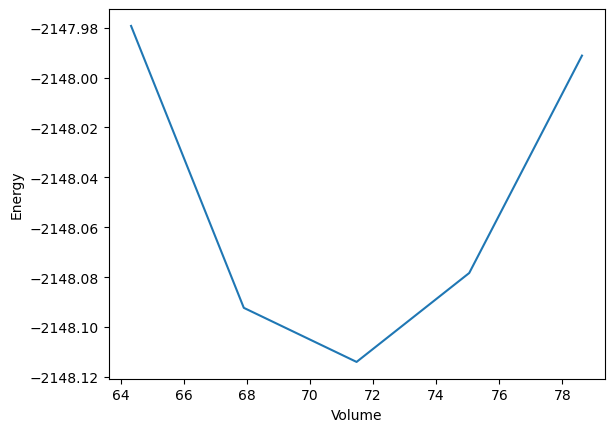

In [16]:
plt.plot(volume_lst, energy_lst)
plt.xlabel("Volume")
plt.ylabel("Energy")